In [57]:
# 1. Basic setup
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [58]:
def load_data_from_folders(paths):
    emotion_map = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    def get_emotion(filename):
        emotion_code = filename.split("-")[2]
        return emotion_map[emotion_code]

    file_list = []
    for path in paths:
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith(".wav"):
                    emotion = get_emotion(file)
                    file_path = os.path.join(root, file)
                    file_list.append((file_path, emotion))
    return pd.DataFrame(file_list, columns=["path", "emotion"])

DATA_PATH_1 = "Audio_Song_Actors_01-24"  # <-- change to your actual path
DATA_PATH_2 = "Audio_Speech_Actors_01-24"

df = load_data_from_folders([DATA_PATH_1, DATA_PATH_2])
print("Total files loaded:", len(df))
print(df.head())


Total files loaded: 2452
                                                path  emotion
0  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
1  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
2  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
3  Audio_Song_Actors_01-24\Actor_01\03-02-01-01-0...  neutral
4  Audio_Song_Actors_01-24\Actor_01\03-02-02-01-0...     calm


<Axes: xlabel='emotion'>

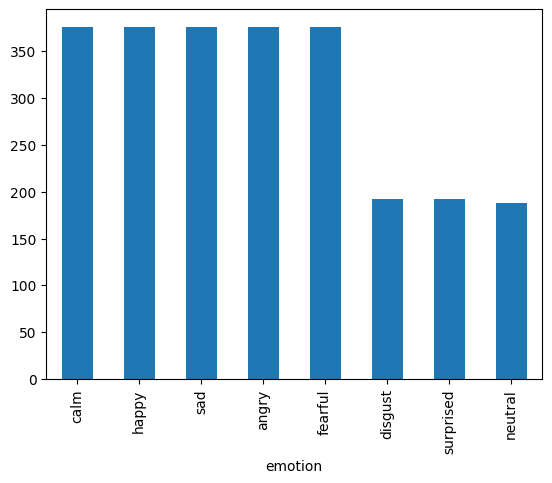

In [70]:
df['emotion'].value_counts().plot(kind='bar')


In [59]:
# Path to extracted audio files
# DATA_PATH1 = "Audio_Song_Actors_01-24" 
# DATA_PATH2 = "Audio_Speech_Actors_01-24"

# # Emotion mapping from RAVDESS
# emotion_map = {
#     '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
#     '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
# }

# # Function to extract emotion from filename
# def get_emotion(filename):
#     emotion_code = filename.split("-")[2]
#     return emotion_map[emotion_code]

# # Create a dataframe of file paths and labels
# def load_data(data_path):
#     file_list = []
#     for root, _, files in os.walk(data_path):
#         for file in files:
#             if file.endswith(".wav"):
#                 emotion = get_emotion(file)
#                 file_path = os.path.join(root, file)
#                 file_path = os.path.normpath(file_path)  # 🔁 Normalize path
#                 file_list.append((file_path, emotion))
#     return pd.DataFrame(file_list, columns=["path", "emotion"])


# df1 = load_data(DATA_PATH1)
# df2 = load_data(DATA_PATH2)
# df = pd.concat([df1, df2], ignore_index=True)
# print(df.tail())


In [60]:
import librosa

test_path = df.iloc[0]["path"]
print("Trying:", test_path)

# Try loading
audio, sr = librosa.load(test_path, sr=None)
print("Duration (s):", len(audio) / sr)


Trying: Audio_Song_Actors_01-24\Actor_01\03-02-01-01-01-01-01.wav
Duration (s): 4.237583333333333


In [61]:
import librosa

test_path = df.iloc[0]["path"]
test_path = os.path.normpath(test_path)  # normalize path in case of backslashes

try:
    audio, sr = librosa.load(test_path, sr=None)
    print("Audio shape:", audio.shape)
    print("Sample rate:", sr)
except Exception as e:
    print("Librosa failed:", e)


Audio shape: (203404,)
Sample rate: 48000


In [62]:
def extract_features(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050)  # Resample
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        
        # Padding or truncating
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        
        return mfcc
    except Exception as e:
        print(f"[ERROR] {file_path} => {e}")
        return None



In [63]:
X = []
y = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    features = extract_features(row["path"])
    if features is not None:
        X.append(features)
        y.append(row["emotion"])

X = np.array(X)
X = X[..., np.newaxis]
print("✅ Shape of X:", X.shape)
print("🎯 Sample label:", y[0])




100%|██████████| 2452/2452 [00:33<00:00, 72.15it/s]

✅ Shape of X: (2452, 40, 174, 1)
🎯 Sample label: neutral


In [64]:
le = LabelEncoder()
y_encoded = to_categorical(le.fit_transform(y))
print("Encoded labels:", y_encoded.shape)


Encoded labels: (2452, 8)


In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

# Conv Layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 174, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Conv Layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten and Dense
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_encoded.shape[1], activation='softmax'))  # num_classes output


In [67]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test)
)


Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.1488 - loss: 25.4054 - val_accuracy: 0.1711 - val_loss: 2.0650
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.1686 - loss: 2.0160 - val_accuracy: 0.2261 - val_loss: 1.8616
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.2512 - loss: 1.8918 - val_accuracy: 0.2668 - val_loss: 1.8311
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.3013 - loss: 1.7504 - val_accuracy: 0.3299 - val_loss: 1.6940
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.3586 - loss: 1.6627 - val_accuracy: 0.4033 - val_loss: 1.5847
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.3919 - loss: 1.5814 - val_accuracy: 0.4012 - val_loss: 1.4698
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4143 - loss: 1.4761 - val_accuracy: 0.4297 - val_loss: 1.4145
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.4678 - loss: 1.3660 - val_accuracy: 0.4868 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

       angry       0.79      0.85      0.82        75
        calm       0.73      0.84      0.78        75
     disgust       0.70      0.54      0.61        39
     fearful       0.69      0.71      0.70        75
       happy       0.68      0.65      0.67        75
     neutral       0.77      0.63      0.70        38
         sad       0.64      0.63      0.64        75
   surprised       0.78      0.82      0.80        39

    accuracy                           0.72       491
   macro avg       0.72      0.71      0.71       491
weighted avg       0.72      0.72      0.72       491



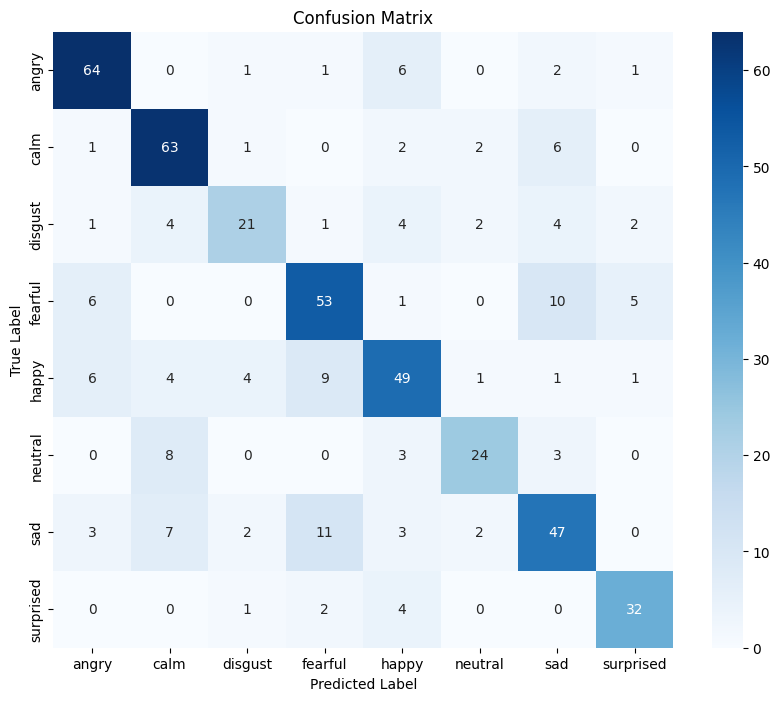

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [71]:
import joblib
model.save('my_model.keras')
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']